<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/feature-pitch/essentia_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essentia feature extraction notebook

Need to pip install Essentia then import libraries.

In [1]:
!pip install essentia

     |████████████████████████████████| 13.7 MB 15.4 MB/s 


In [71]:
import os
import numpy as np
import math
import essentia
import essentia.standard as es
import IPython.display as ipd
from scipy.signal import find_peaks

%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# todo - remove? This isn't needed if using gdown to download the dataset
#from google.colab import drive
#drive.mount('/content/drive')

Download the dataset and unzip.

In [4]:
# Download and unzip dataset
!gdown --id 1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql

Downloading...
From: https://drive.google.com/uc?id=1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql
To: /content/SASSE_tiny_16.zip
100% 40.9M/40.9M [00:00<00:00, 44.6MB/s]


In [5]:
!unzip -q SASSE_tiny_16.zip

In [6]:
TRAIN_PATH = '/content/SASSE_tiny_16/train'
VALID_PATH = '/content/SASSE_tiny_16/validation'

# Essentia setup

In [10]:
test_file = os.path.join(TRAIN_PATH, '60_train_sample_101.wav')

loader = es.MonoLoader(filename=test_file)
test_audio = loader()

In [11]:
ipd.Audio(test_file)

In [12]:
window = es.Windowing(type='hann')
spectrum = es.Spectrum()
mfcc = es.MFCC()

In [13]:
test_frame = test_audio[int(0.25*44100) : int(0.25*44100) + 1024]
frame_spectrum = spectrum(window(test_frame))
mfcc_bands, mfcc_coeffs = mfcc(frame_spectrum)

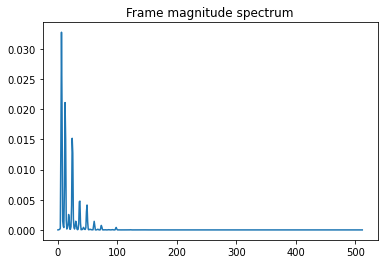

In [14]:
plt.plot(frame_spectrum)
plt.title("Frame magnitude spectrum")
plt.show()

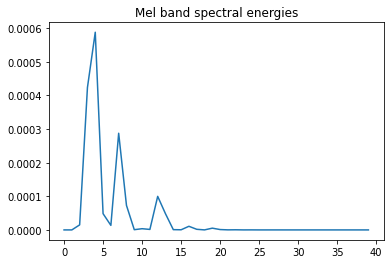

In [15]:
plt.plot(mfcc_bands)
plt.title("Mel band spectral energies")
plt.show()

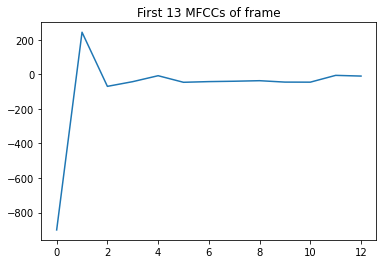

In [16]:
plt.plot(mfcc_coeffs)
plt.title("First 13 MFCCs of frame")
plt.show()

### Doing computations on all frames of an audio file

In [17]:
mfccs = []
mel_bands = []
frame_size = 1024
hop_size = 512

In [18]:
for frame in es.FrameGenerator(test_audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True):
  mfcc_bands, mfcc_coeffs = mfcc(spectrum(window(frame)))
  mfccs.append(mfcc_coeffs)
  mel_bands.append(mfcc_bands)

In [19]:
mfccs = essentia.array(mfccs).T
mel_bands = essentia.array(mel_bands).T

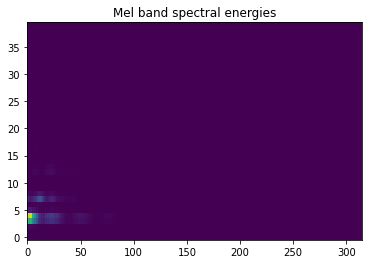

In [20]:
plt.imshow(mel_bands[:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("Mel band spectral energies")
plt.show()

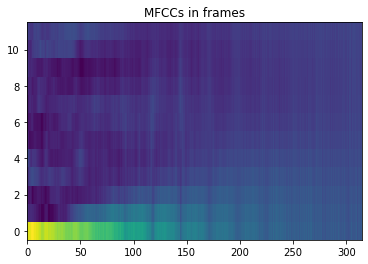

In [21]:
plt.imshow(mfccs[1:,:], aspect='auto', origin='lower', interpolation='none')
plt.title("MFCCs in frames")
plt.show()

## Essentia pools

In [22]:
pool = essentia.Pool()

In [ ]:
for frame in es.FrameGenerator(test_audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True):
  mfcc_bands, mfcc_coeffs = mfcc(spectrum(window(frame)))
  pool.add('lowlevel.mfcc', mfcc_coeffs)
  pool.add('lowlevel.mfcc_bands', mfcc_bands)

# From 2019 ASA steelpan analysis project

In [36]:
# This is the original, unedited function for reference
def featureExtraction(sample):

    # Load audio using EasyLoader
    # EasyLoader normalizes to -6dB and downsamples to 44.1 kHz
    loader = es.EasyLoader(filename = sample.encode('utf-8'))
    # Can test using both EasyLoader and MonoLoader
    #loader = es.MonoLoader(filename = sample.encode('utf-8'))
    audio = loader()


    # Find the start and stop points of the sample
    startStop = es.StartStopSilence(threshold=-60)

    startFrame = 0
    stopFrame = 0

    for frame in es.FrameGenerator(audio, 64, 32):
        startFrame, stopFrame = startStop(frame)

    startTime = float(startFrame * 32) / 44100.0
    stopTime = float((stopFrame * 32) + 64) / 44100.0

    # Trim the audio file
    trimmer = es.Trimmer(startTime=startTime, endTime=stopTime)
    trimmedAudio = trimmer(audio)

    # Calculate LogAttackTime, Temporal Centroid, Effective Duration, Loudness
    envelope = es.Envelope()
    logAttackTime = es.LogAttackTime()
    tempCentroid = es.Centroid(range = (len(audio)-1)/44100.0)
    effectiveDuration = es.EffectiveDuration()
    level = es.Loudness()

    lat, attackStart, attackStop = logAttackTime(envelope(trimmedAudio))
    temporalCentroid = tempCentroid(envelope(trimmedAudio))
    duration = effectiveDuration(audio)
    loud = level(audio)

    # Set up functions for processing loop
    windowing = es.Windowing(size=2048, zeroPadding=2048-1323)
    spectrum = es.Spectrum(size=2048)
    square = es.UnaryOperator(type="square")
    centralMoments = es.CentralMoments()
    distributionShape = es.DistributionShape()
    hfc = es.HFC()

    centroid = es.Centroid(range=1025)
    variance = es.Variance()
    pool = essentia.Pool()
    binFreq = 44100. / 2048.

    for frame in es.FrameGenerator(trimmedAudio, frameSize=1323, hopSize=441):
        windowed = windowing(frame)
        magSpectrum = spectrum(windowed)
        powSpectrum = square(magSpectrum)

        spectralCentroid = centroid(powSpectrum)
        spread = spectralSpread(powSpectrum, spectralCentroid)
        spectralCentroid *= binFreq
        spread *= binFreq

        moments = centralMoments(magSpectrum)
        spectralVariance, spectralSkewness, spectralKurtosis = distributionShape(moments)
        spectralDeviation = math.sqrt(spectralVariance)
        highFreq = hfc(magSpectrum)

        pool.add('centroid', spectralCentroid)
        pool.add('variance', spectralVariance)
        pool.add('specdev', spectralDeviation)
        pool.add('spread', spread)
        pool.add('hfc', highFreq)
        pool.add('duration', duration)
        pool.add('specSkew', spectralSkewness)
        pool.add('specKurt', spectralKurtosis)
        pool.add('loud', loud)


    poolAgg = es.PoolAggregator(defaultStats=['mean'])
    stats = poolAgg(pool)

    return {
        'lat': lat,
        'centroid': stats['centroid.mean'],
        'variance': stats['variance.mean'],
        'specdev': stats['specdev.mean'],
        'spread': stats['spread.mean'],
        'hfc': stats['hfc.mean'],
        'tempCentroid': temporalCentroid,
        'duration': duration,
        'specSkew': stats['specSkew.mean'],
        'specKurt': stats['specKurt.mean'],
        'loud': loud
    }

Essentia algo reference: https://essentia.upf.edu/algorithms_reference.html

Algorithms to implement
- **AutoCorrelation** - https://essentia.upf.edu/reference/std_AutoCorrelation.html
- ConstantQ - https://essentia.upf.edu/reference/std_ConstantQ.html
- FFT - https://essentia.upf.edu/reference/std_FFT.html
- NSGConstant Q - https://essentia.upf.edu/reference/std_NSGConstantQ.html
  - Regular ConstantQ is probably preferable since it works for smaller frames
- DerivativeSFX? - https://essentia.upf.edu/reference/std_DerivativeSFX.html
- **Zero crossing rate** - https://essentia.upf.edu/reference/std_ZeroCrossingRate.html
- BFCC - https://essentia.upf.edu/reference/std_BFCC.html
  - Bark filter
- Bark Bands - https://essentia.upf.edu/reference/std_BarkBands.html
- Flux - https://essentia.upf.edu/reference/std_Flux.html
- HFC - https://essentia.upf.edu/reference/std_HFC.html
- GFCC - https://essentia.upf.edu/reference/std_GFCC.html
  - Gammatone freq cepstral coefficients
- **MFCC** - https://essentia.upf.edu/reference/std_MFCC.html
- MelBands - https://essentia.upf.edu/reference/std_MelBands.html
- Power spectrum - https://essentia.upf.edu/reference/std_PowerSpectrum.html
- **Roll-off** - https://essentia.upf.edu/reference/std_RollOff.html
- Spectral centroid time - https://essentia.upf.edu/reference/std_SpectralCentroidTime.html
  - Is this the centroid measure that I want?
- Spectral complexity - https://essentia.upf.edu/reference/std_SpectralComplexity.html
- **Spectral contrast** - https://essentia.upf.edu/reference/std_SpectralContrast.html
- **Spectral peaks** - https://essentia.upf.edu/reference/std_SpectralPeaks.html
- Spectral Whitening? - https://essentia.upf.edu/reference/std_SpectralWhitening.html
- Spectrum - https://essentia.upf.edu/reference/std_Spectrum.html
  - I think this is the magnitude spectrum output we'd normally calculate from an FFT
- Spectrum to cent? - https://essentia.upf.edu/reference/std_SpectrumToCent.html
- **Strong peak** - https://essentia.upf.edu/reference/std_StrongPeak.html
- Triangular bands? - https://essentia.upf.edu/reference/std_TriangularBands.html
- Triangular bark bands? - https://essentia.upf.edu/reference/std_TriangularBarkBands.html
- Onset detection? - https://essentia.upf.edu/reference/std_OnsetDetection.html
  - I could include a flag for any frames within a certain number of ms of an onset
- **Central moments** - https://essentia.upf.edu/reference/std_CentralMoments.html
- Centroid - https://essentia.upf.edu/reference/std_Centroid.html
- **Distribution shape** - https://essentia.upf.edu/reference/std_DistributionShape.html
- **Energy** - https://essentia.upf.edu/reference/std_Energy.html
- **Flatness** - https://essentia.upf.edu/reference/std_Flatness.html

In [105]:
# todo - This is currently designed to process an entire sample at a time.
# Rewrite this function to iterate over the entire dataset and generate the frame by frame
# data for training/testing.

def featureExtraction(sample, samplerate=48000, frame_size=2048, hop_size=512, threshold=-60):
  '''
  Documentation

  Parameters
  ----------
  sample : ndarray (n,)
  
  samplerate : int
    Audio samplerate

  frame_size : int
    Number of samples per audio frame

  hop_size : int
    Number of samples between successive audio frames

  threshold : int (-inf, 0)
    Power threshold for trimming the audio file

  
  Returns
  -------


  '''

  # Load audio using EasyLoader
  # EasyLoader normalizes to -6dB and downsamples to 44.1 kHz
  loader = es.EasyLoader(filename = sample,
                         sampleRate=samplerate)
  # Can test using both EasyLoader and MonoLoader
  #loader = es.MonoLoader(filename = sample.encode('utf-8'), sampleRate=samplerate)
  audio = loader()


  # Find the start and stop points of the sample
  startStop = es.StartStopSilence(threshold=threshold)

  startFrame = 0
  stopFrame = 0

  for frame in es.FrameGenerator(audio, 64, 32): # todo - what are these 64, 32 for?
    startFrame, stopFrame = startStop(frame)

  startTime = float(startFrame * 32) / float(samplerate) # todo - why 32?
  stopTime = float((stopFrame * 32) + 64) / float(samplerate) # todo - why 32/64?

  # Trim the audio file
  trimmer = es.Trimmer(startTime=startTime, endTime=stopTime)
  trimmedAudio = trimmer(audio)

  # Set up functions for processing loop
  windowing = es.Windowing(size=2048, zeroPadding=0) # todo - Do I want/need zero padding?
  spectrum = es.Spectrum(size=2048) # todo - change to frame_size
  square = es.UnaryOperator(type="square")
  centralMoments = es.CentralMoments()
  distributionShape = es.DistributionShape()
  hfc = es.HFC()

  #test
  autocorrelation = es.AutoCorrelation()

  centroid = es.Centroid(range=1025) # todo - it looks like this should be (frame_size/2)+1
  variance = es.Variance()
  pool = essentia.Pool()
  binFreq = float(samplerate / 2048.) # todo - probably frame_size

  for frame in es.FrameGenerator(trimmedAudio, frameSize=frame_size, hopSize=hop_size): # todo - check
    windowed = windowing(frame)
    magSpectrum = spectrum(windowed)
    powSpectrum = square(magSpectrum)

    # test
    autocor = autocorrelation(windowed)

    spectralCentroid = centroid(powSpectrum)
    spread = spectralSpread(powSpectrum, spectralCentroid) # todo - what is this function again and why aren't we using the Essentia spread?
    spectralCentroid *= binFreq
    spread *= binFreq

    moments = centralMoments(magSpectrum)
    spectralVariance, spectralSkewness, spectralKurtosis = distributionShape(moments)
    spectralDeviation = math.sqrt(spectralVariance)
    highFreq = hfc(magSpectrum)

    #test
    pool.add('autocorrelation', autocor)

    pool.add('centroid', spectralCentroid)
    pool.add('variance', spectralVariance)
    pool.add('specdev', spectralDeviation)
    pool.add('spread', spread)
    pool.add('hfc', highFreq)
    pool.add('specSkew', spectralSkewness)
    pool.add('specKurt', spectralKurtosis)


  poolAgg = es.PoolAggregator(defaultStats=['mean'])
  stats = poolAgg(pool)

  autocor_peaks = find_peaks(stats['autocorrelation.mean'])
  print(autocor_peaks[0][0] * samplerate / 2048.)

  return {
    #test
    'autocorrelation': np.argmax(stats['autocorrelation.mean']),
    
    'centroid': stats['centroid.mean'],
    'variance': stats['variance.mean'],
    'specdev': stats['specdev.mean'],
    'spread': stats['spread.mean'],
    'hfc': stats['hfc.mean'],
    'specSkew': stats['specSkew.mean'],
    'specKurt': stats['specKurt.mean'],
    }

In [106]:
# todo - figure out the difference between this and the spread (variance) returned by DistributionShape from Essentia

def spectralSpread(spectrum, spectralCentroid):

  magSpectrum = np.array(spectrum)
  bins = np.array(range(len(spectrum)))

  if (np.sum(magSpectrum) == 0):
    return 0

  spread = np.square((bins - spectralCentroid) * magSpectrum)
  spread = np.sum(spread) / np.sum(magSpectrum)
  spread = math.sqrt(spread)

  return spread

In [107]:
extraction = featureExtraction(test_file)

2132.8125


In [62]:
extraction

{'autocorrelation': 0,
 'centroid': 338.52313232421875,
 'hfc': 0.35230278968811035,
 'specKurt': 26.178985595703125,
 'specSkew': 4.2865447998046875,
 'specdev': 0.036276087164878845,
 'spread': 1.2169206142425537,
 'variance': 0.001929891761392355}

In [ ]:
def main():
    """
    audioFiles = []
    dir = 'Audio Files/Painted Lead/Test'
    for file in os.listdir(dir):
        if file.endswith('.wav'):
            # Join the directory path with the file name to feed to algorithm.
            audioFiles.append(os.path.join(dir, file))

    output = [['file', 'centroid']]

    # Run feature extraction on all audio files
    for audio in audioFiles:
        extraction = featureExtraction(audio)
        # If you use 'audio' as the output, you get the full filepath
        # output.append([audio, extraction['centroid']])
        # If you append 'os.path.basename(audio)', then you get just the filename (preferred)
        output.append([os.path.basename(audio), extraction['centroid']])
        """

    dir2 = 'Audio Files/Painted Lead'
    for folder in os.listdir(dir2):
        if os.path.isdir(os.path.join(dir2,folder)):
            audioFiles = []
            for file in os.listdir(os.path.join(dir2,folder)):
                if file.endswith('.wav'):
                    audioFiles.append(os.path.join(dir2,folder,file))
            output = [['file', 'centroid', 'variance', 'specdev', 'spread',\
            'lat', 'hfc','tempCentroid','duration', 'specSkew', 'specKurt',\
            'loudness']]
            # Run feature extraction
            for audio in audioFiles:
                extraction = featureExtraction(audio)
                output.append([os.path.basename(audio),extraction['centroid'],\
                extraction['variance'], extraction['specdev'], extraction['spread'],\
                extraction['lat'], extraction['hfc'], extraction['tempCentroid'],\
                extraction['duration'], extraction['specSkew'], extraction['specKurt'],\
                extraction['loud']])
            results = np.array(output)
            np.savetxt('Results/' + folder + '.csv', results, fmt='%s', delimiter=',')



if __name__ == '__main__':
    main()